In [1]:
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 7.8 MB/s 
     |████████████████████████████████| 182 kB 44.4 MB/s 
     |████████████████████████████████| 166 kB 14.6 MB/s 
     |████████████████████████████████| 63 kB 680 kB/s 
     |████████████████████████████████| 166 kB 5.7 MB/s 
     |████████████████████████████████| 162 kB 31.3 MB/s 
     |████████████████████████████████| 162 kB 40.4 MB/s 
     |████████████████████████████████| 158 kB 35.7 MB/s 
     |████████████████████████████████| 157 kB 51.8 MB/s 
     |████████████████████████████████| 157 kB 44.4 MB/s 
     |████████████████████████████████| 157 kB 34.0 MB/s 
     |████████████████████████████████| 157 kB 37.3 MB/s 
     |████████████████████████████████| 157 kB 43.8 MB/s 
     |████████████████████████████████| 157 kB 30.3 MB/s 
     |████████████████████████████████| 157 kB 14.3 MB/s 
     |████████████████████████████████| 156 kB 36.3 MB/s 


In [2]:
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
!pip install rdkit-pypi -qqq

     |████████████████████████████████| 29.5 MB 1.1 MB/s 


In [8]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls ./gdrive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
MyDrive


# New Section

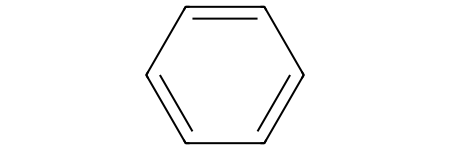

In [9]:
import datetime
import pandas as pd
import math, sys, random, os
import numpy as np
import time
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
import json
import gzip
import six


from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

Chem.MolFromSmiles('c1ccccc1')

In [10]:
import math, sys, random, os
import numpy as np
import time
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
import json
import gzip
import six

import os

project_root = os.path.dirname('/content/gdrive/MyDrive/scscore-master/')
# project_root = os.path.dirname(os.path.dirname(__file__))

score_scale = 5.0
min_separation = 0.25

FP_len = 1024
FP_rad = 2

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

class SCScorer():
    def __init__(self, score_scale=score_scale):
        self.vars = []
        self.score_scale = score_scale
        self._restored = False

    def restore(self, weight_path=os.path.join(project_root, 'models', 'full_reaxys_model_1024bool', 'model.ckpt-10654.as_numpy.pickle'), FP_rad=FP_rad, FP_len=FP_len):
        self.FP_len = FP_len; self.FP_rad = FP_rad
        self._load_vars(weight_path)
        print('Restored variables from {}'.format(weight_path))

        if 'uint8' in weight_path or 'counts' in weight_path:
            def mol_to_fp(self, mol):
                if mol is None:
                    return np.array((self.FP_len,), dtype=np.uint8)
                fp = AllChem.GetMorganFingerprint(mol, self.FP_rad, useChirality=True) # uitnsparsevect
                fp_folded = np.zeros((self.FP_len,), dtype=np.uint8)
                for k, v in six.iteritems(fp.GetNonzeroElements()):
                    fp_folded[k % self.FP_len] += v
                return np.array(fp_folded)
        else:
            def mol_to_fp(self, mol):
                if mol is None:
                    return np.zeros((self.FP_len,), dtype=np.float32)
                return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, self.FP_rad, nBits=self.FP_len,
                    useChirality=True), dtype=np.bool)
        self.mol_to_fp = mol_to_fp

        self._restored = True
        return self

    def smi_to_fp(self, smi):
        if not smi:
            return np.zeros((self.FP_len,), dtype=np.float32)
        return self.mol_to_fp(self, Chem.MolFromSmiles(smi))

    def apply(self, x):
        if not self._restored:
            raise ValueError('Must restore model weights!')
        # Each pair of vars is a weight and bias term
        for i in range(0, len(self.vars), 2):
            last_layer = (i == len(self.vars)-2)
            W = self.vars[i]
            b = self.vars[i+1]
            x = np.matmul(x, W) + b
            if not last_layer:
                x = x * (x > 0) # ReLU
        x = 1 + (score_scale - 1) * sigmoid(x)
        return x

    def get_score_from_smi(self, smi='', v=False):
        if not smi:
            return ('', 0.)
        fp = np.array((self.smi_to_fp(smi)), dtype=np.float32)
        if sum(fp) == 0:
            if v: print('Could not get fingerprint?')
            cur_score = 0.
        else:
            # Run
            cur_score = self.apply(fp)
            if v: print('Score: {}'.format(cur_score))
        mol = Chem.MolFromSmiles(smi)
        if mol:
            smi = Chem.MolToSmiles(mol, isomericSmiles=True, kekuleSmiles=True)
        else:
            smi = ''
        return (smi, cur_score)

    def _load_vars(self, weight_path):
        if weight_path.endswith('pickle'):
            import cPickle as pickle
            with open(weight_path, 'rb') as fid:
                self.vars = pickle.load(fid)
                self.vars = [x.tolist() for x in self.vars]
        elif weight_path.endswith('json.gz'):
            with gzip.GzipFile(weight_path, 'r') as fin:    # 4. gzip
                json_bytes = fin.read()                      # 3. bytes (i.e. UTF-8)
                json_str = json_bytes.decode('utf-8')            # 2. string (i.e. JSON)
                self.vars = json.loads(json_str)
                self.vars = [np.array(x) for x in self.vars]


if __name__ == '__main__':
    model = SCScorer()
    model.restore(os.path.join(project_root, 'models', 'full_reaxys_model_1024bool', 'model.ckpt-10654.as_numpy.json.gz'))
    smis = ['CCCOCCC', 'CCCNc1ccccc1']
    for smi in smis:
        (smi, sco) = model.get_score_from_smi(smi)
        print('%.4f <--- %s' % (sco, smi))

    model = SCScorer()
    model.restore(os.path.join(project_root, 'models', 'full_reaxys_model_2048bool', 'model.ckpt-10654.as_numpy.json.gz'), FP_len=2048)
    smis = ['CCCOCCC', 'CCCNc1ccccc1']
    for smi in smis:
        (smi, sco) = model.get_score_from_smi(smi)
        print('%.4f <--- %s' % (sco, smi))

    model = SCScorer()
    model.restore(os.path.join(project_root, 'models', 'full_reaxys_model_1024uint8', 'model.ckpt-10654.as_numpy.json.gz'))
    smis = ['CCCOCCC', 'CCCNc1ccccc1']
    for smi in smis:
        (smi, sco) = model.get_score_from_smi(smi)
        print('%.4f <--- %s' % (sco, smi))

Restored variables from /content/gdrive/MyDrive/scscore-master/models/full_reaxys_model_1024bool/model.ckpt-10654.as_numpy.json.gz
1.4323 <--- CCCOCCC
1.8913 <--- CCCNC1=CC=CC=C1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Restored variables from /content/gdrive/MyDrive/scscore-master/models/full_reaxys_model_2048bool/model.ckpt-10654.as_numpy.json.gz
1.3429 <--- CCCOCCC
1.8087 <--- CCCNC1=CC=CC=C1
Restored variables from /content/gdrive/MyDrive/scscore-master/models/full_reaxys_model_1024uint8/model.ckpt-10654.as_numpy.json.gz
1.3853 <--- CCCOCCC
1.7232 <--- CCCNC1=CC=CC=C1
